In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
%matplotlib inline

In [2]:
from nmt_run import *

translating es to en
callhome es-en configuration
--------------------------------------------------
loading info_dict from=./mfcc_out/info.dict


 31%|███       | 42569/138708 [00:00<00:00, 425687.36it/s]

--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 138708/138708 [00:00<00:00, 435096.42it/s]


--------------------------------------------------
saving info dict in: ./mfcc_out/buckets_sp.dict
all done ...
--------------------------------------------------
showing buckets for category: fisher_dev
number of buckets=20, width of each bucket=50
index | width | num   
    0 |     0 |     18
    1 |    50 |    455
    2 |   100 |    566
    3 |   150 |    403
    4 |   200 |    324
    5 |   250 |    279
    6 |   300 |    215
    7 |   350 |    238
    8 |   400 |    161
    9 |   450 |    165
   10 |   500 |    121
   11 |   550 |    114
   12 |   600 |    115
   13 |   650 |    113
   14 |   700 |     87
   15 |   750 |     87
   16 |   800 |     78
   17 |   850 |     81
   18 |   900 |     71
   19 |   950 |    286
--------------------------------------------------
showing buckets for category: fisher_dev2
number of buckets=20, width of each bucket=50
index | width | num   
    0 |     0 |     14
    1 |    50 |    344
    2 |   100 |    495
    3 |   150 |    402
    4 |   200

/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer2/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer


In [3]:
model_files = [f for f in os.listdir(os.path.dirname(model_fil))
                   if os.path.basename(model_fil).replace('.model','') in f]
print(model_files)

[]


In [4]:
max_model_fil = max(model_files, key=lambda s: int(s.split('_')[-1].split('.')[0]))

ValueError: max() arg is an empty sequence

In [ ]:
max_model_fil

In [5]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model not found


In [6]:
log_dev_fil_name

'fsh_again/dev_sen-138819_hwy2-dec2_emb-64-h-384__sp_en_c_lstm_drpt-0.2_noise-0_l2-0.000001_32_32_32_2_3_3_1DCNN_BN_LN_enc-2.log'

In [7]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.loadtxt(log_dev_fil_name, delimiter=',', skiprows=5).transpose()

StopIteration: 

NameError: name 'log_test' is not defined

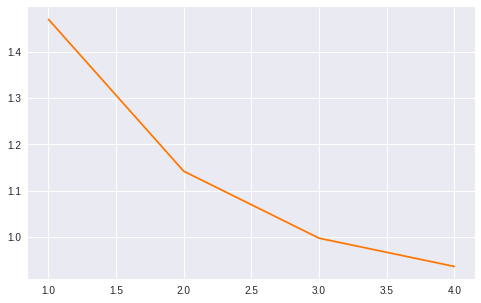

In [8]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax2.set_ylim(0, 0.9)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [9]:
key='fisher_dev'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])

In [10]:
cat_speech_path = os.path.join(out_path, key)

In [11]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
pred_sents, utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|          | 0/3977 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 1


b=6,l=2.12,avg=3.23: 100%|██████████| 3977/3977 [01:23<00:00, 35.67it/s] 

********** dev mean loss=3.2330
-
--------------------------------------------------------------------------------


In [12]:
display_words(m_dict, v_dict, pred_sents[-50:], utts[-50:], dec_key)

Utterance: 20051019_210146_289_fsp-B-96
+---------+----------------------------------------------------+
| es ref  | mhm sí es cierto ya                                |
+---------+----------------------------------------------------+
| en ref  | mhm yes is true yeah                               |
+---------+----------------------------------------------------+
| en pred | 'always'always'she'r'r'r'might'number'high'might'h |
|         | igh'high'might'might'might'might'with'with'withñññ |
|         | 'with'with'with'sex'sex't--finally'st'st'he'he'he' |
|         | he'he'he'he'he'he'he'st'st'st'st'st'st'st'st'st'st |
|         | 'yes'st'st'st'st'st'st'how'how't--finally'he'yes'h |
|         | e'he'he'he'he'he'he'he'he'might'might'might'might' |
|         | might'might'might'might'might'might'might          |
+---------+----------------------------------------------------+
Utterance: 20051018_210744_280_fsp-A-84
+---------+----------------------------------------------------+
| es ref  

In [13]:
b, h, r = calc_bleu(m_dict, v_dict, pred_sents[:n], utts[:n], dec_key)
print("bleu score = {0:.2f}%".format(corpus_bleu(r, h) * 100))

bleu score = 0.00%
